In [5]:
from model import unet_constructor
from create_dataset import preprocess_set

import torch
from pathlib import Path
import matplotlib.pylab as plt
from tqdm import tqdm
import numpy as np


data_dir = Path.home() / 'Desktop/retina/DRIVE/'
results_dir = Path.home() / 'OneDrive - Nexus365/retina_fundus'

data_test = preprocess_set(data_dir, 'test')
data_train = preprocess_set(data_dir, 'training')

model_path = results_dir / 'retina-fundus_unet_BCE_20191010_191040_adam_lr0.00256_batch256' / 'model_best.pth.tar'

model = unet_constructor(1, 1)
state = torch.load(model_path, map_location = 'cpu')
model.load_state_dict(state['state_dict'])
model.eval()



Preprocessing training...: 100%|██████████| 20/20 [00:01<00:00, 19.13it/s]


UNetBase(
  (initial_block): ConvBlock(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (down_blocks): ModuleList(
    (0): DownSimple(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownSimple(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2,

100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


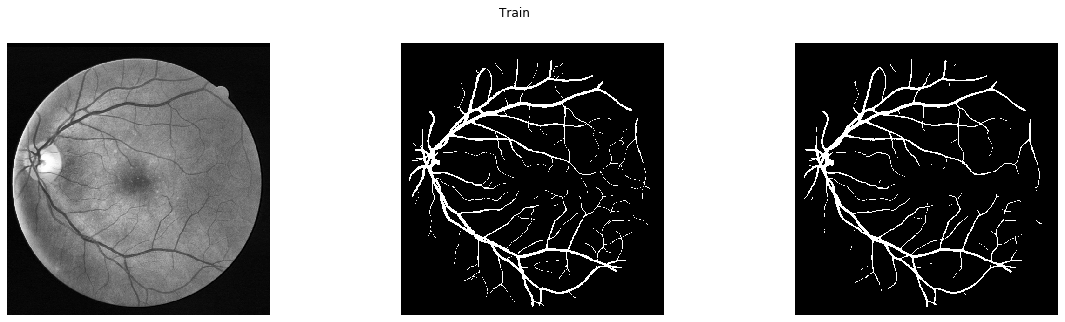

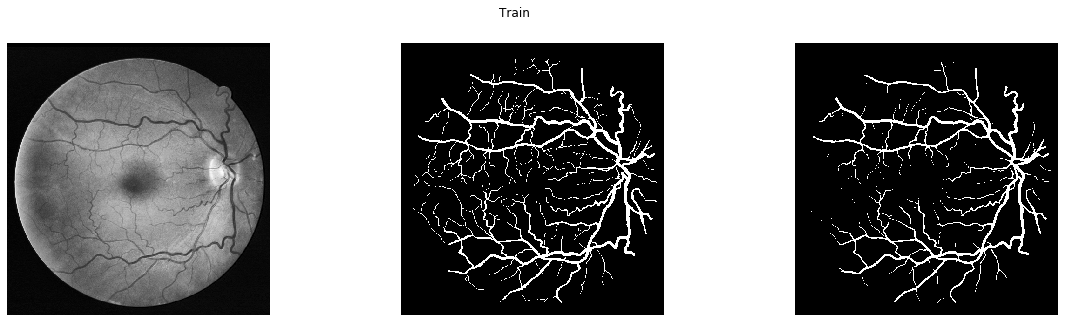

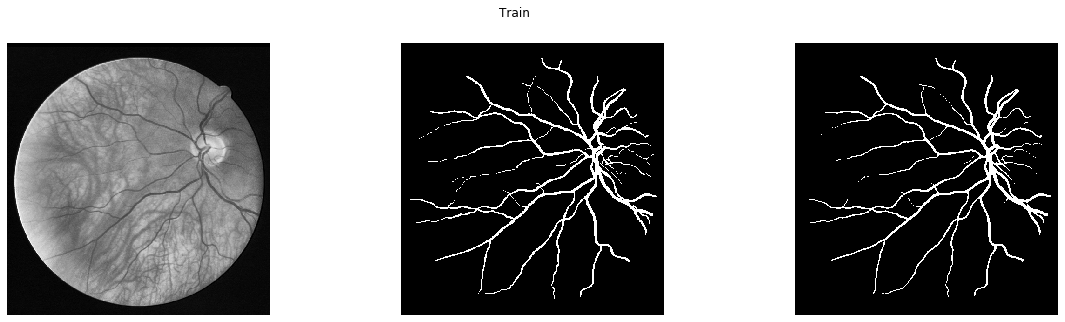

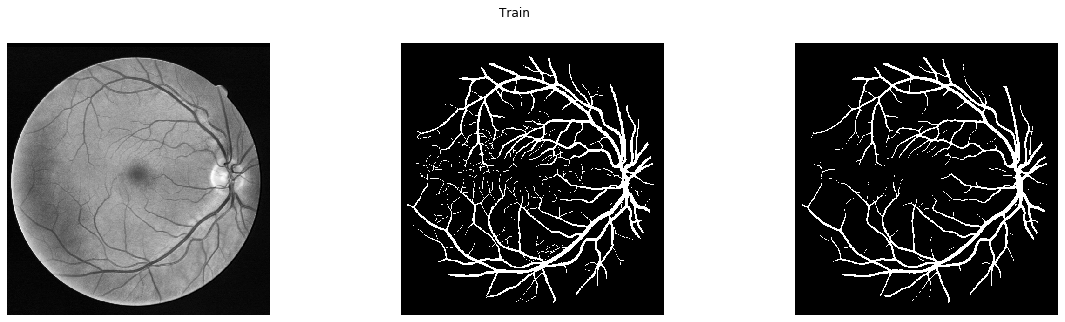

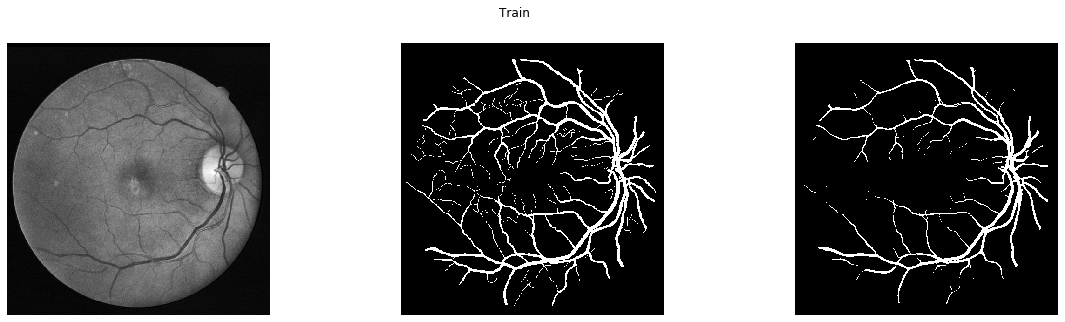

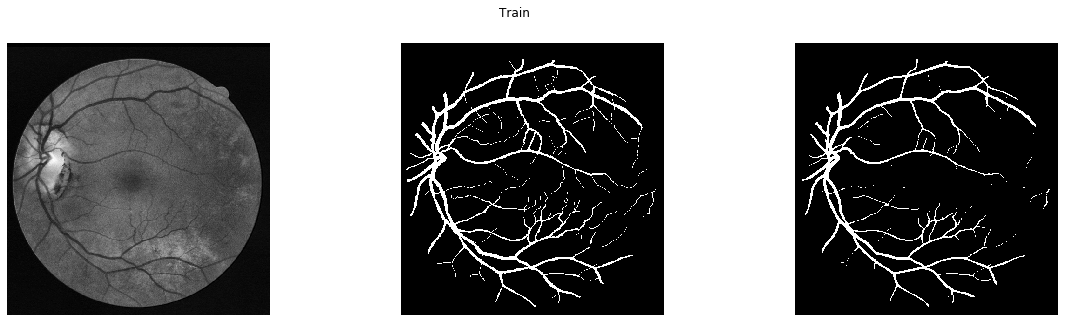

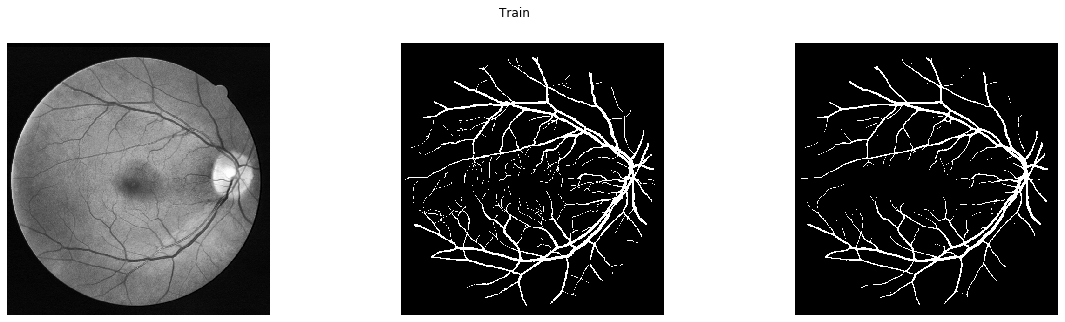

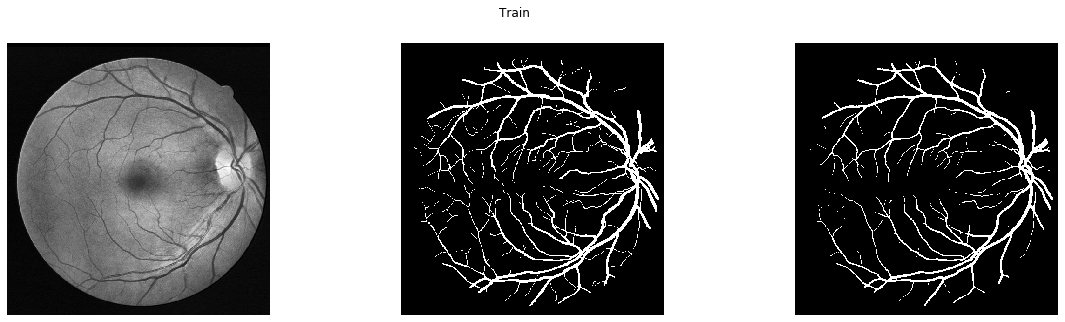

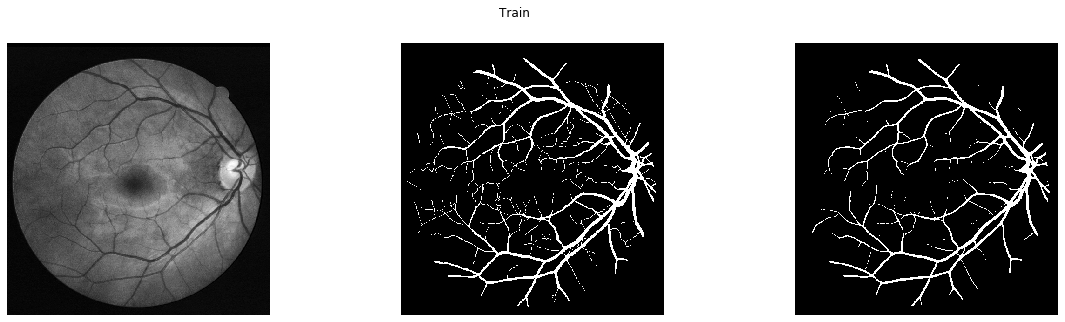

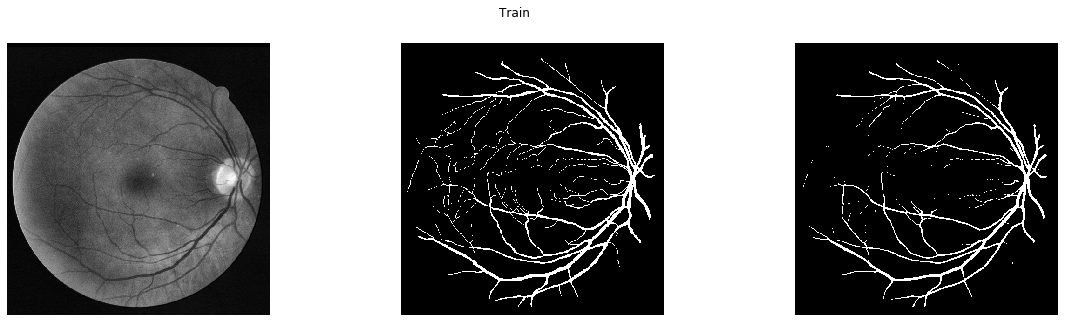

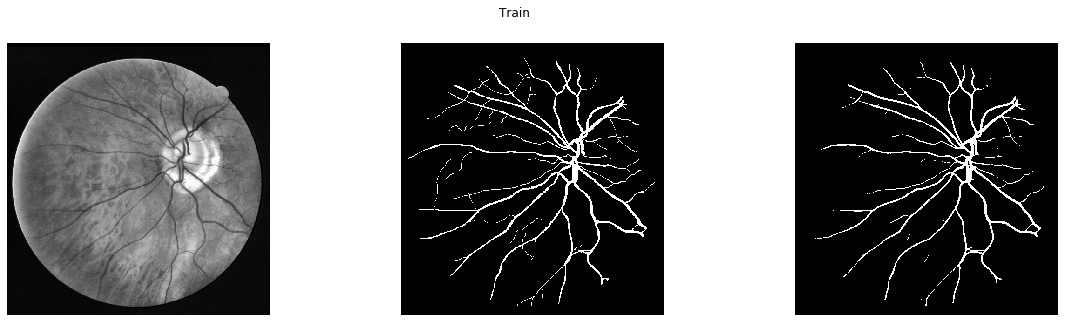

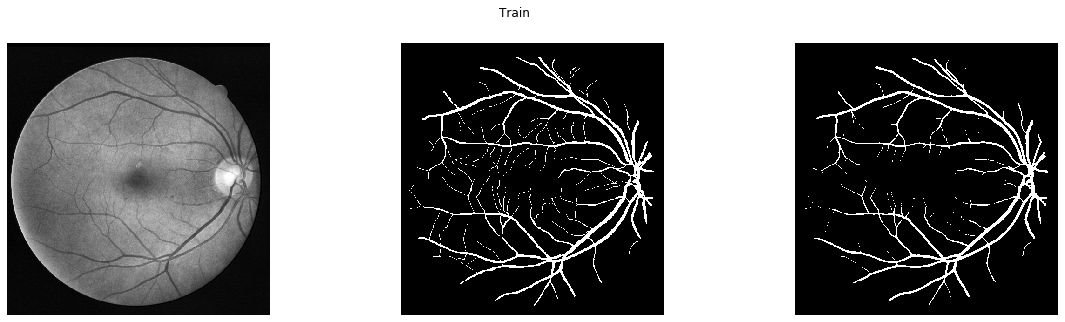

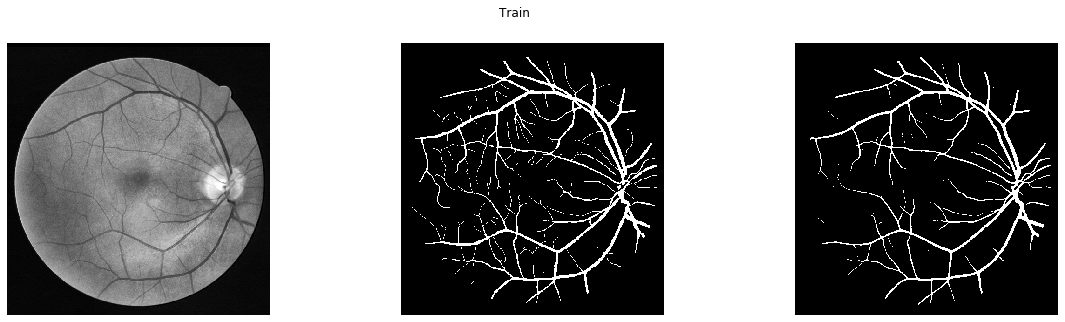

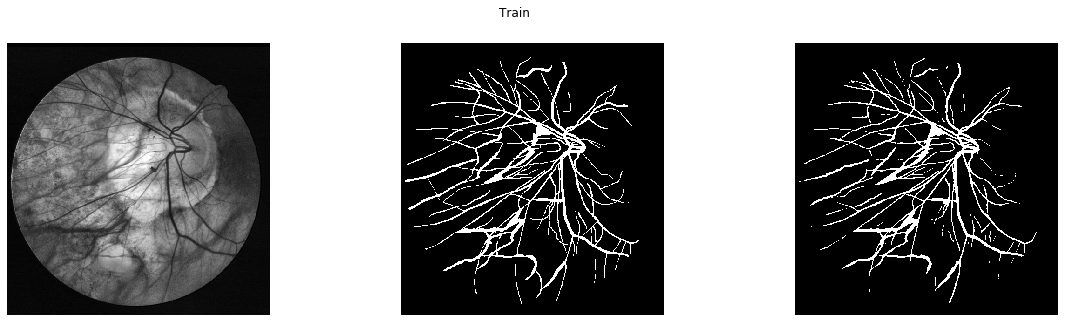

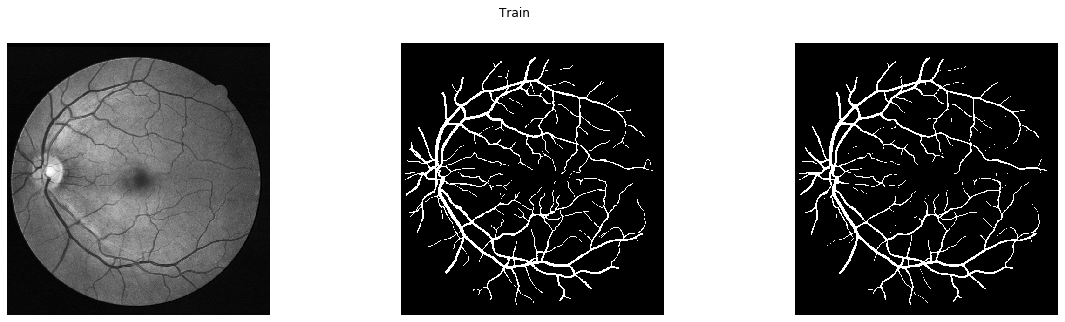

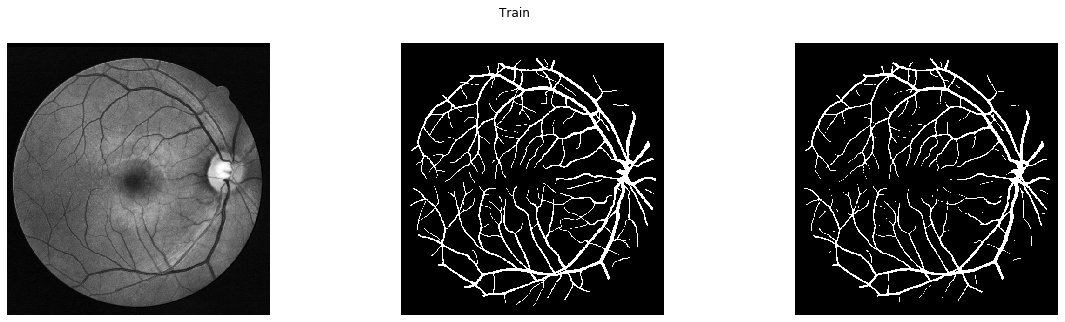

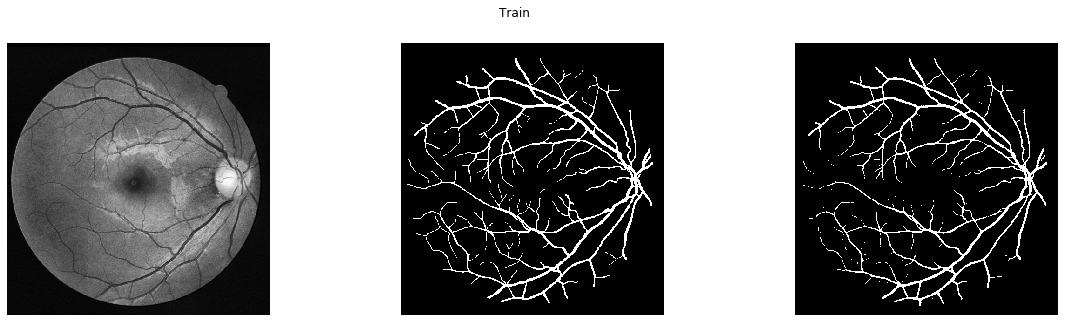

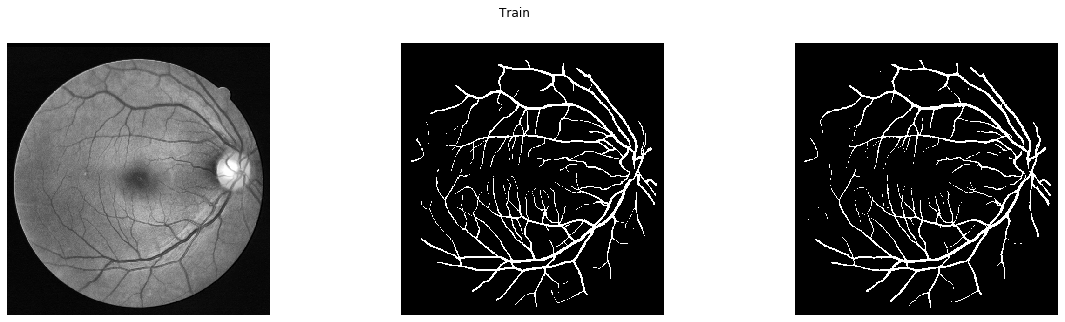

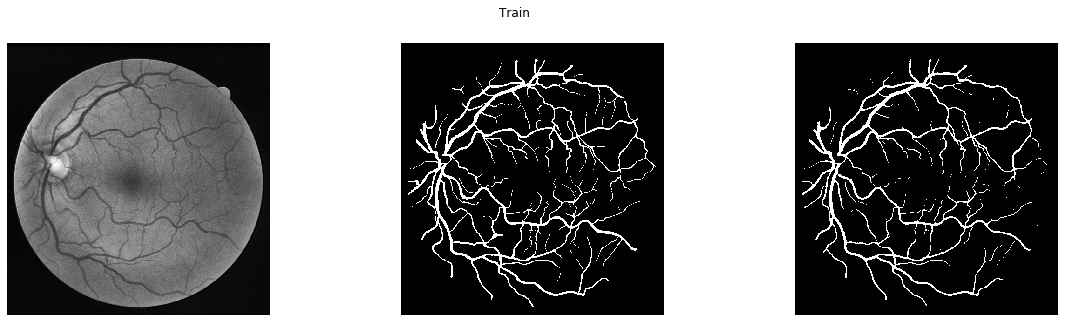

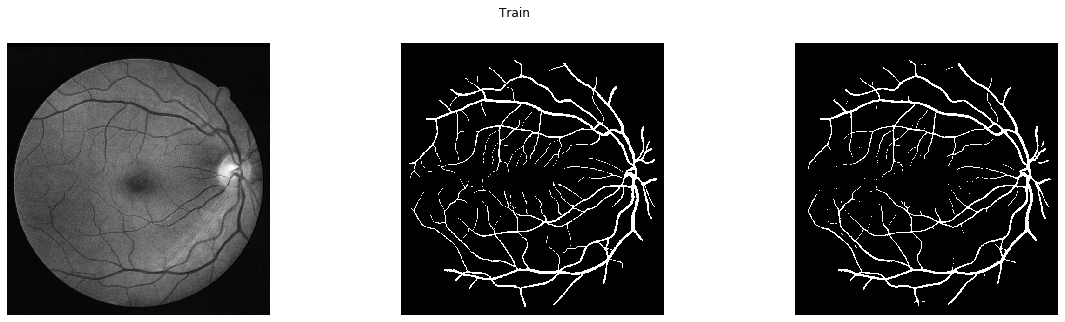

In [6]:
def get_dice_coeff(y_pred, y_true, threshold = 0.5):
    y_true, y_pred = y_true>threshold, y_pred>threshold
    
    eps = 1e-12
    inter = (y_true & y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    dice_coeff = (2 * inter + eps) / (total + eps)
    
    return dice_coeff



thresholds2check = np.arange(0.05, 1.0, 0.05)
avg_dice = np.zeros(len(thresholds2check))
with torch.no_grad():
    for Xo,Yo in tqdm(data_train):
        X = torch.from_numpy(Xo[None, None])
        Y = torch.from_numpy(Yo[None, None])
        
        preds = model(X)
        pred = preds[0,0].detach().cpu().numpy() 
        
                    
        for ith, th in enumerate(thresholds2check):
            dice_coeff = get_dice_coeff(pred, Yo, th)
            avg_dice[ith] += dice_coeff
        
        
        fig, axs = plt.subplots(1, 3, figsize = (20, 5))
        axs[0].imshow(Xo, cmap='gray')
        axs[1].imshow(Yo, cmap='gray')
        axs[2].imshow(pred>0.5, cmap='gray')
        
        fig.suptitle('Train')
        #fig.suptitle(f'Dice Coeff = {dice_coeff}')
        for ax in axs:
            ax.axis('off')
        
avg_dice /=  len(data_train)       
        



Best threshold = 0.35000000000000003


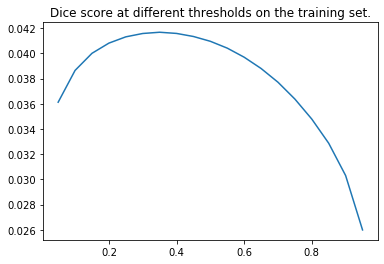

In [11]:
plt.figure()
plt.plot(thresholds2check, avg_dice)
plt.title('Dice score at different thresholds on the training set.')
ind = np.argmax(avg_dice)


threshold_test = thresholds2check[ind]
print(f'Best threshold = {threshold_test}')


100%|██████████| 20/20 [01:17<00:00,  3.90s/it]


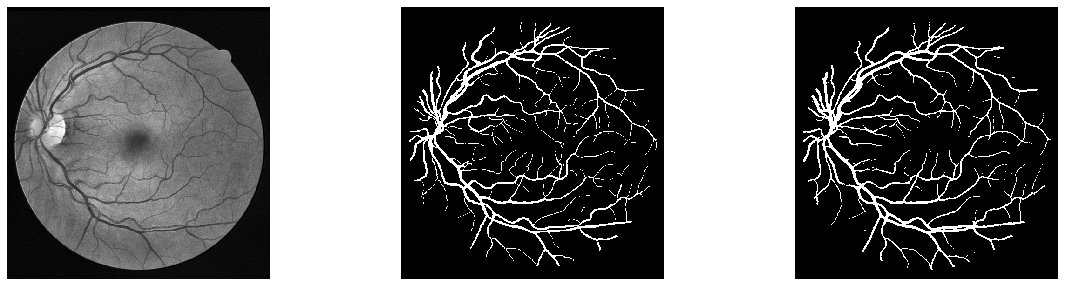

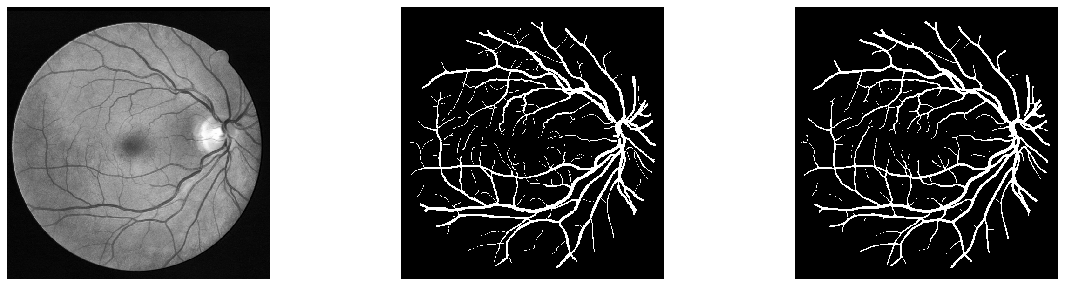

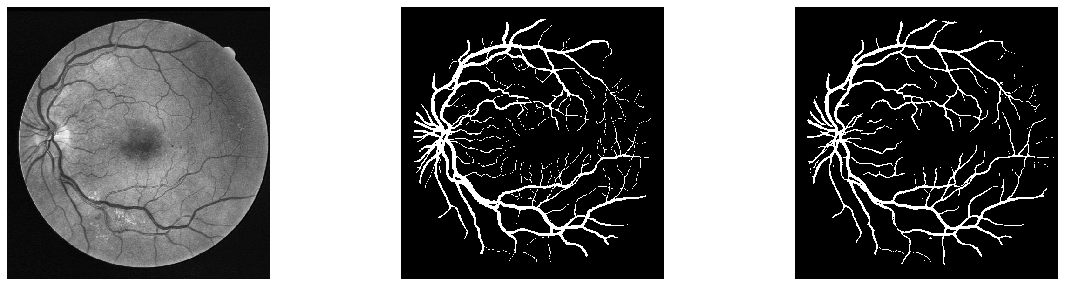

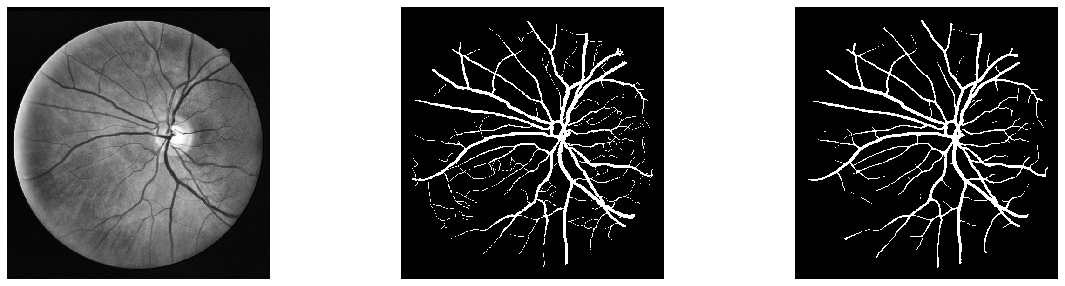

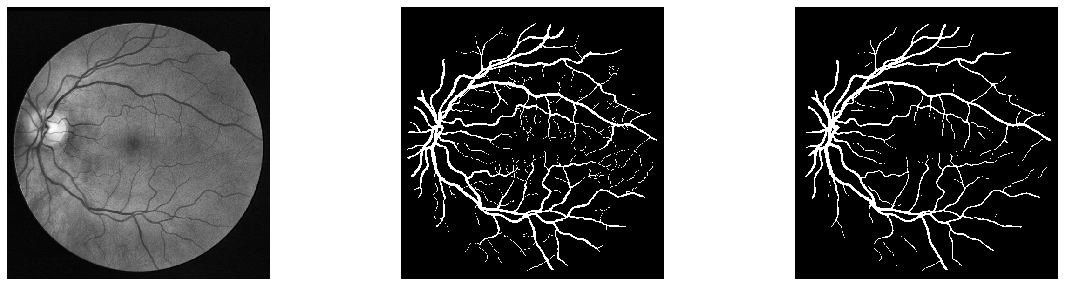

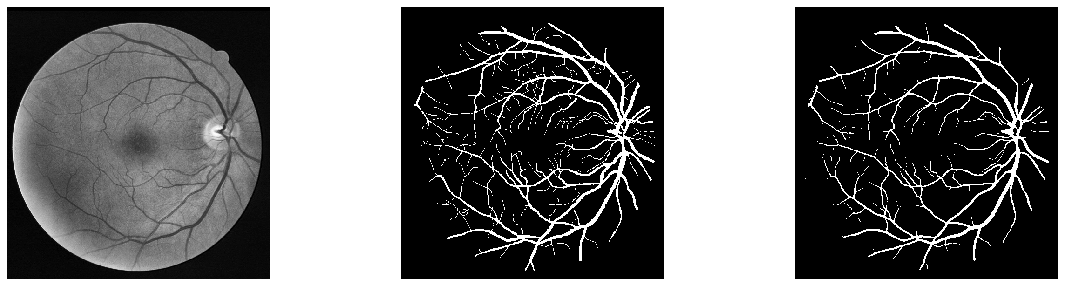

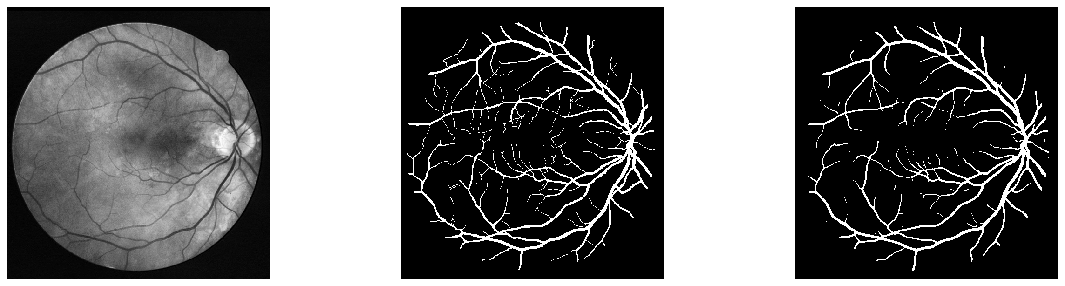

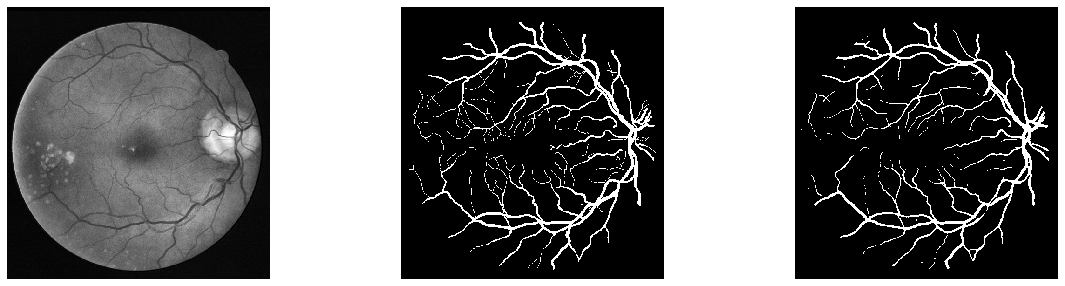

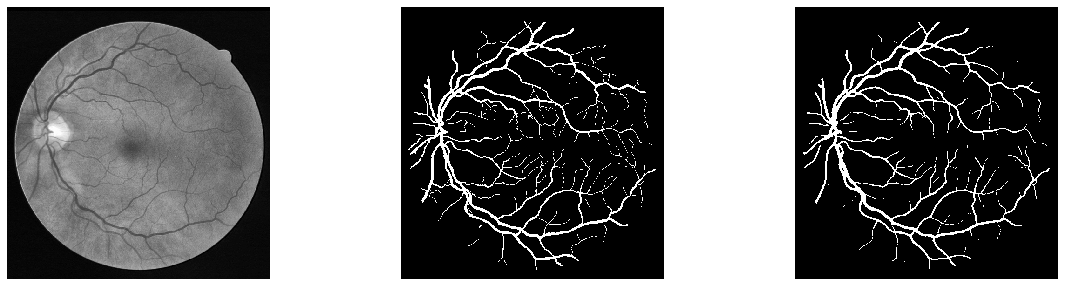

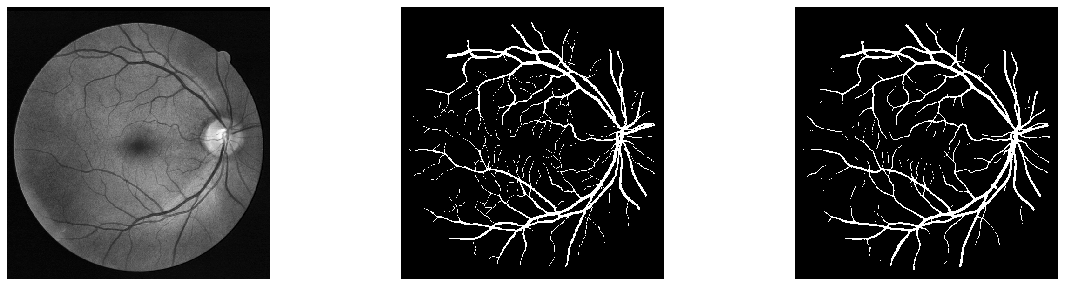

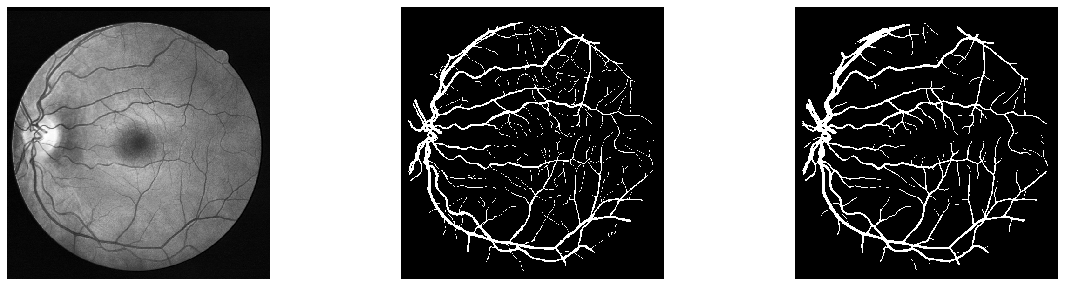

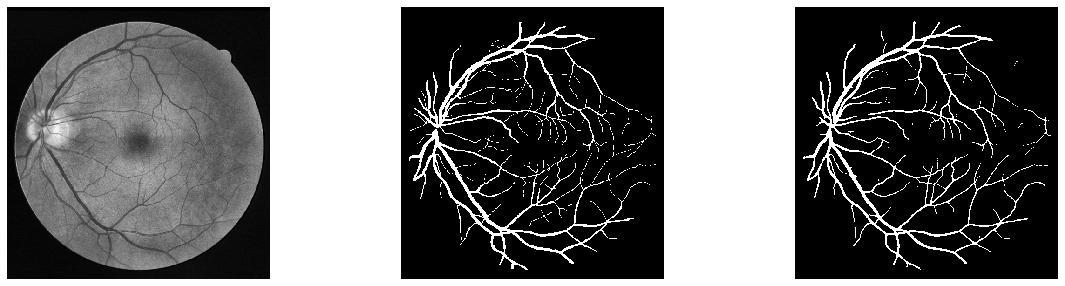

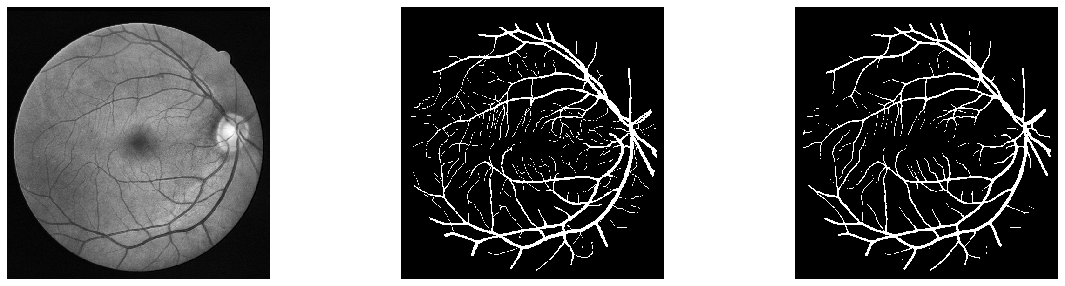

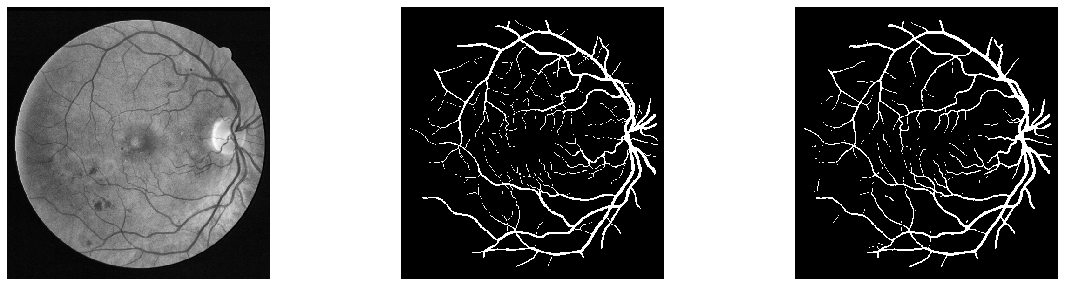

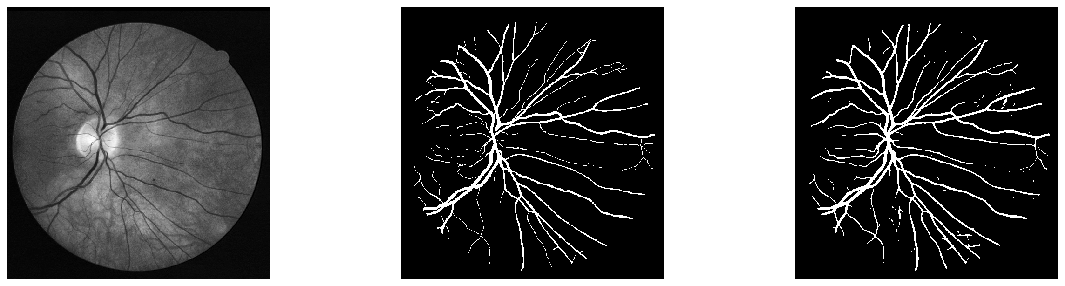

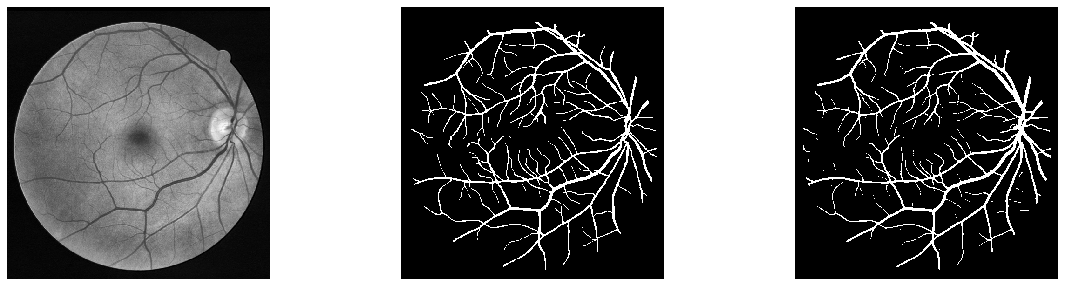

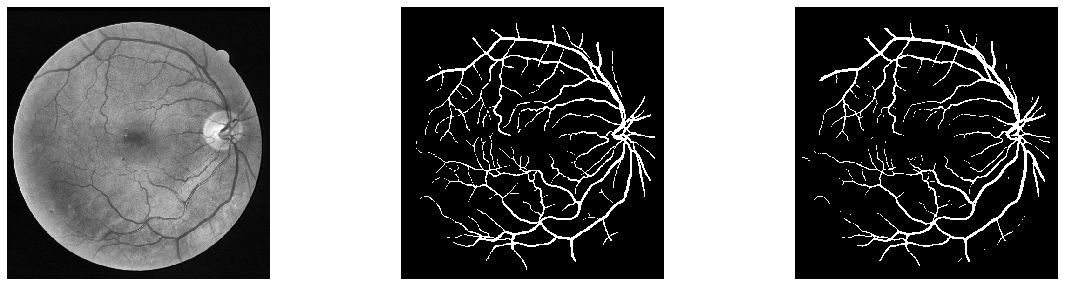

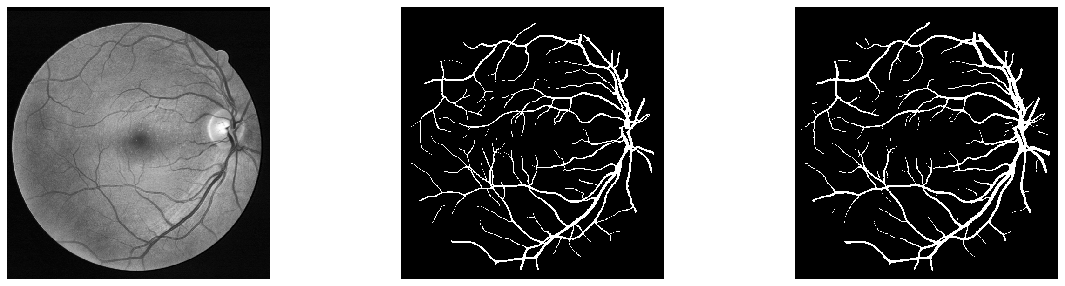

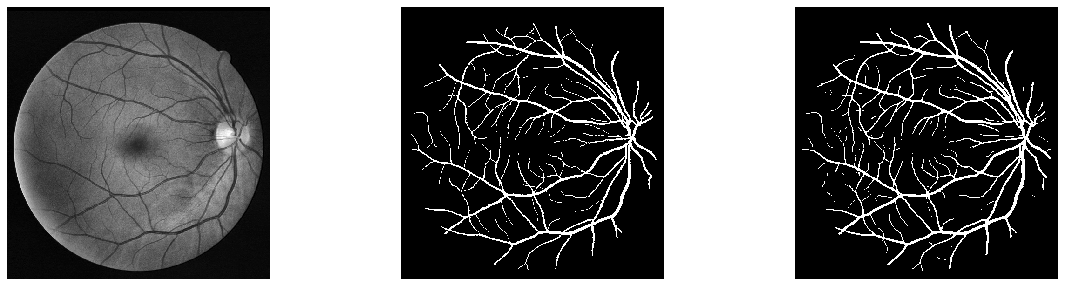

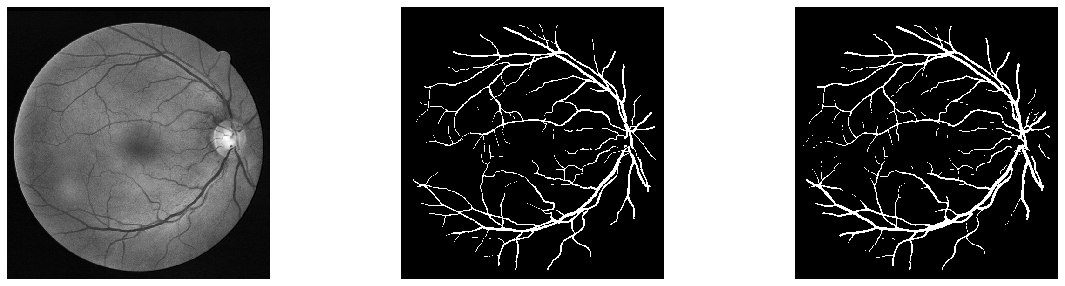

In [15]:
avg_test_dice = 0
with torch.no_grad():
    for Xo,Yo in tqdm(data_test):
        X = torch.from_numpy(Xo[None, None])
        Y = torch.from_numpy(Yo[None, None])
        
        preds = model(X)
        pred = preds[0,0].detach().cpu().numpy() 
        
        dice_coeff = get_dice_coeff(pred, Yo, threshold_test)
        avg_test_dice += dice_coeff
        
        fig, axs = plt.subplots(1, 3, figsize = (20, 5))
        axs[0].imshow(Xo, cmap='gray')
        axs[1].imshow(Yo, cmap='gray')
        axs[2].imshow(pred>threshold_test, cmap='gray')
        
        #fig.suptitle(f'Dice Coeff = {dice_coeff}')
        for ax in axs:
            ax.axis('off')
        
avg_test_dice /=  len(data_test)       


In [14]:
print(f'Test average Dice coeff : {avg_test_dice}')

Test average Dice coeff : 0.8141594350613209
